In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    "../input/2s/15day_0201_0215.csv", usecols=["ds", "y"], parse_dates=["ds"]
)
print(df.shape)
df.head()

(648000, 2)


,ds,y
0,2021-02-01 19:00:00,12.0
1,2021-02-01 19:00:02,7.0
2,2021-02-01 19:00:04,1.0
3,2021-02-01 19:00:06,16.0
4,2021-02-01 19:00:08,19.0


In [3]:
df.tail()

,ds,y
647995,2021-02-16 18:59:50,19.0
647996,2021-02-16 18:59:52,19.0
647997,2021-02-16 18:59:54,19.0
647998,2021-02-16 18:59:56,19.0
647999,2021-02-16 18:59:58,19.0


In [4]:
train = df[df['ds'] < '2021-2-10']
valid = df[df['ds'] >= '2021-2-10']
valid["days"] = valid["ds"].apply(lambda x: x.day)
valid["hour"] = valid["ds"].apply(lambda x: x.hour)
valid["days_hour"] = valid["days"].astype(str) + "_" + valid["hour"].astype(str)
valid = valid.groupby("days_hour")["y"].agg("mean").reset_index()

In [5]:
cap = np.max(train.y)
floor = np.min(train.y)

In [6]:
def objective(trial: Trial) -> float:
    params = {
        "changepoint_range": trial.suggest_discrete_uniform(
            "changepoint_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
        "changepoint_prior_scale": trial.suggest_discrete_uniform(
            "changepoint_prior_scale", 0.001, 0.5, 0.001
        ),
        "seasonality_prior_scale": trial.suggest_discrete_uniform(
            "seasonality_prior_scale", 1, 25, 0.5
        ),
#         "yearly_fourier": trial.suggest_int("yearly_fourier", 5, 15),
#         "monthly_fourier": trial.suggest_int("monthly_fourier", 3, 12),
#         "weekly_fourier": trial.suggest_int("weekly_fourier", 3, 7),
#         "quaterly_fourier": trial.suggest_int("quaterly_fourier", 3, 10),
#         "yearly_prior": trial.suggest_discrete_uniform("yearly_prior", 1, 25, 0.5),
#         "monthly_prior": trial.suggest_discrete_uniform("monthly_prior", 1, 25, 0.5),
#         "weekly_prior": trial.suggest_discrete_uniform("weekly_prior", 1, 25, 0.5),
#         "quaterly_prior": trial.suggest_discrete_uniform("quaterly_prior", 1, 25, 0.5),
        "growth": "logistic",
        "seasonality_mode": "additive",
        "yearly_seasonality": False,
        "weekly_seasonality": True,
        "daily_seasonality": True,
    }
    # fit_model
    m = Prophet(**params)
    train["cap"] = cap
    train["floor"] = floor
    m.fit(train)
    future = m.make_future_dataframe(periods=163, freq="H")

    future["cap"] = cap
    future["floor"] = floor

    forecast = m.predict(future)
    valid_forecast = forecast.tail(163)
    val_rmse = mean_squared_error(valid.y, valid_forecast.yhat, squared=False)

    return val_rmse

In [7]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=15)

[I 2021-05-16 13:19:37,286] A new study created in memory with name: no-name-db5575ab-bbeb-4774-8f99-c711f5589571
[I 2021-05-16 13:24:01,534] Trial 0 finished with value: 10.499390116576576 and parameters: {'changepoint_range': 0.8560000000000001, 'n_changepoints': 35, 'changepoint_prior_scale': 0.366, 'seasonality_prior_scale': 15.5}. Best is trial 0 with value: 10.499390116576576.
[I 2021-05-16 13:27:27,698] Trial 1 finished with value: 6.061870041305653 and parameters: {'changepoint_range': 0.8230000000000001, 'n_changepoints': 22, 'changepoint_prior_scale': 0.030000000000000002, 'seasonality_prior_scale': 22.0}. Best is trial 1 with value: 6.061870041305653.
[I 2021-05-16 13:30:05,939] Trial 2 finished with value: 5.9301764493853995 and parameters: {'changepoint_range': 0.89, 'n_changepoints': 31, 'changepoint_prior_scale': 0.011, 'seasonality_prior_scale': 24.5}. Best is trial 2 with value: 5.9301764493853995.
[I 2021-05-16 13:32:19,529] Trial 3 finished with value: 10.31332894272

In [8]:
prophet_params = study.best_params
prophet_params["growth"] = "logistic"
prophet_params["seasonality_mode"] = "additive"
prophet_params["weekly_seasonality"] = True
prophet_params["daily_seasonality"] = True
prophet_params["yearly_seasonality"] = False
m = Prophet(**prophet_params)

In [9]:
train['cap'] = cap
train['floor'] = floor

m.fit(train)

future = m.make_future_dataframe(periods=144, freq="H")
future['cap'] = cap
future['floor'] = floor

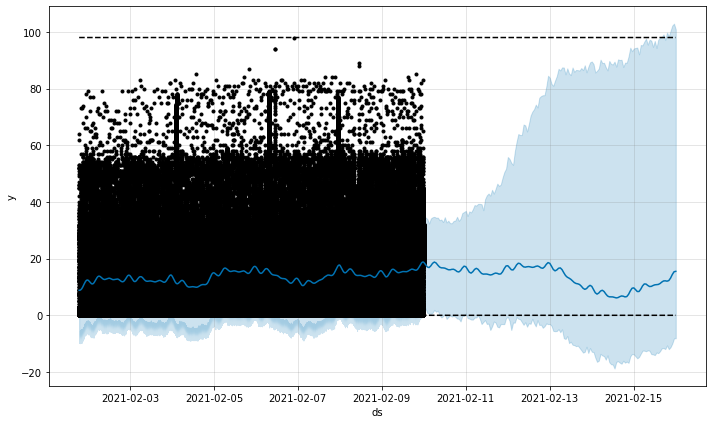

In [10]:
forecast = m.predict(future)
forecast_plot = m.plot(forecast)

In [11]:
cap = np.max(df.y)
floor = np.min(df.y)

In [12]:
df['cap'] = cap
df['floor'] = floor

m = Prophet(**prophet_params)
m.fit(df)

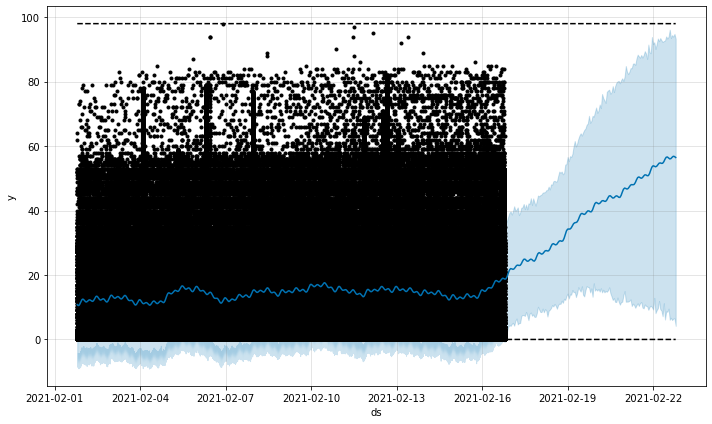

In [13]:
future = m.make_future_dataframe(periods=144, freq="H")
future['cap'] = cap
future['floor'] = floor
forecast1 = m.predict(future)
fig1 = m.plot(forecast1)

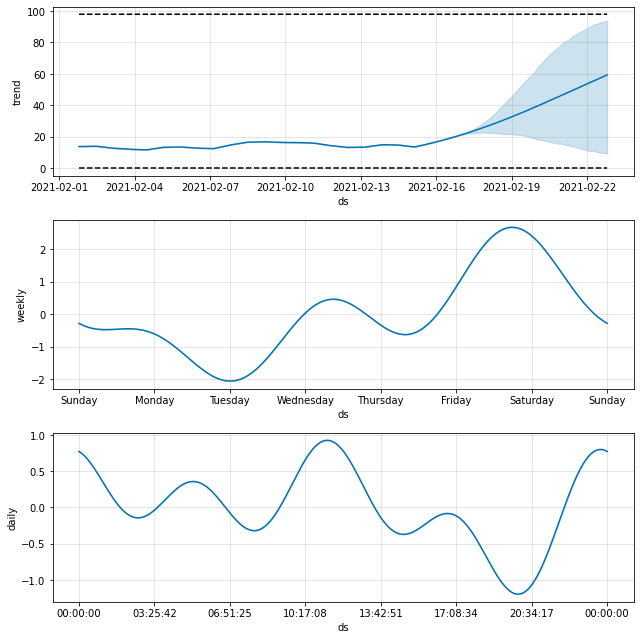

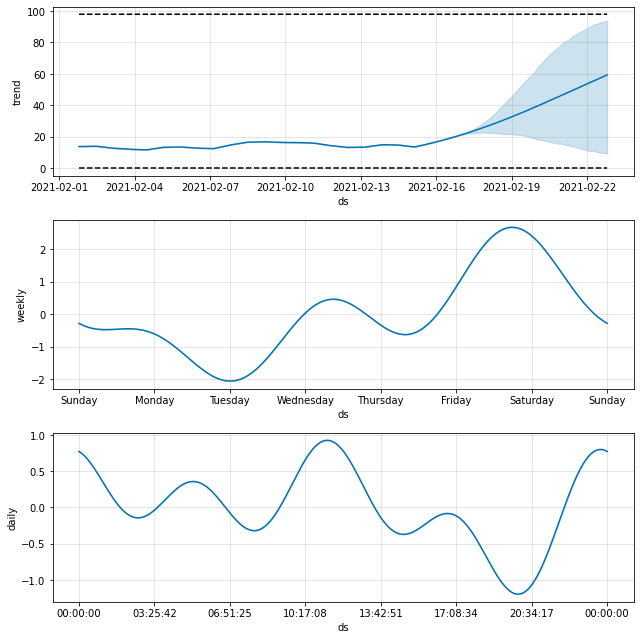

In [14]:
m.plot_components(forecast1)